In [1]:
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from tqdm import tqdm
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import tenseal as ts

In [13]:
df = pd.read_csv(r"C:\Users\invite1\Downloads\Manigandan Ramadasan\Code\top_feature_df.csv")
grouped = df.groupby('Label')
df = grouped.apply(lambda x: x.sample(grouped.size().min(), random_state=73).reset_index(drop=True))
x = df.drop(["Label"], axis = 1)
y = df["Label"]
# scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)
x_train, x_test_20, y_train, y_test_20 = train_test_split(x, y, test_size=0.20, random_state=42)
x_train=torch.from_numpy(x_train).float()
x_test_20=torch.from_numpy(x_test_20).float()
y_train=torch.from_numpy(np.array(y_train)).float().unsqueeze(1)
y_test_20=torch.from_numpy(np.array(y_test_20)).float().unsqueeze(1)
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test_20.shape}")
print(f"y_test shape: {y_test_20.shape}")

x_train shape: torch.Size([681185, 40])
y_train shape: torch.Size([681185, 1])
x_test shape: torch.Size([170297, 40])
y_test shape: torch.Size([170297, 1])


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [95]:
torch.manual_seed(42)
class NN(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=n_features, out_features=32)
        self.layer_2 = nn.Linear(in_features=32, out_features=16)
        self.layer_3 = nn.Linear(in_features=16, out_features=8)
        self.layer_4 = nn.Linear(in_features=8, out_features=4)
        self.layer_5 = nn.Linear(in_features=4, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer_1(x)
        x = x*x
#         x = self.relu(x)
#         x = torch.sigmoid(x)
        x = self.layer_2(x)
        x = x*x
#         x = self.relu(x)
#         x = torch.sigmoid(x)
        x = self.layer_3(x)
        x = x*x
#         x = self.relu(x)
#         x = torch.sigmoid(x)
        x = self.layer_4(x)
        x = x*x
#         x = self.relu(x)
#         x = torch.sigmoid(x)
        x = self.layer_5(x)
        return x

In [6]:
torch.manual_seed(42)
class NN(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=n_features, out_features=24)
        self.layer_2 = nn.Linear(in_features=24, out_features=8)
        self.layer_3 = nn.Linear(in_features=8, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer_1(x)
        x = x*x
        x = self.layer_2(x)
        x = x*x
        x = self.layer_3(x)
        return x

In [5]:
def train(model, optim, criterion, scheduler, x, y, epochs):
    x, y = x.to(device), y.to(device)
    loss_dict = {}
    for e in range(1, epochs + 1):
        model.train()
        out = model(x)
        loss = loss_fn(out, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        scheduler.step(loss)
        loss_dict[e] = loss.data
        if e%10 == 0:
            print(f"Loss at epoch {e}: {loss.data} || Learning Rate: {optimizer.param_groups[0]['lr']}")
    return model, loss_dict

In [6]:
def accuracy_fn(y_true, y_pred):
    
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct / len(y_pred)) * 100 
    return acc

NN(
  (layer_1): Linear(in_features=40, out_features=24, bias=True)
  (layer_2): Linear(in_features=24, out_features=8, bias=True)
  (layer_3): Linear(in_features=8, out_features=1, bias=True)
  (relu): ReLU()
)
Loss at epoch 10: 0.6286932229995728 || Learning Rate: 0.01
Loss at epoch 20: 0.5125330090522766 || Learning Rate: 0.01
Loss at epoch 30: 0.4397149682044983 || Learning Rate: 0.01
Loss at epoch 40: 0.40544867515563965 || Learning Rate: 0.01
Loss at epoch 50: 0.3522739112377167 || Learning Rate: 0.01
Loss at epoch 60: 0.28649401664733887 || Learning Rate: 0.01
Loss at epoch 70: 0.22770853340625763 || Learning Rate: 0.01
Loss at epoch 80: 0.2023332267999649 || Learning Rate: 0.01
Loss at epoch 90: 0.17852692306041718 || Learning Rate: 0.01
Loss at epoch 100: 0.16262991726398468 || Learning Rate: 0.01
Loss at epoch 110: 0.14685100317001343 || Learning Rate: 0.01
Loss at epoch 120: 0.14072878658771515 || Learning Rate: 0.01
Loss at epoch 130: 0.13585832715034485 || Learning Rate: 0

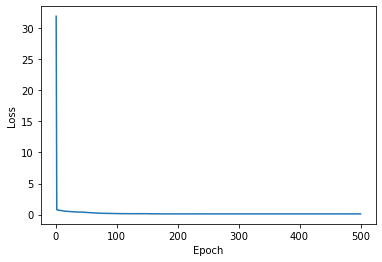

In [7]:
n_features = x_train.shape[1]
model = NN(n_features).to(device)
print(model)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(),  lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001)

EPOCH = 500
t_start = time.time()
model, loss_dict = train(model, optimizer, loss_fn, scheduler, x_train, y_train, EPOCH)
t_end = time.time()
print(f"Training Time: {int(t_end - t_start)} seconds")

x_coord, y_coord = zip(*(loss_dict.items()))
plt.plot(x_coord,y_coord)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [18]:
def accuracy(model, x, y):
    t_start = time.time()
    out = torch.sigmoid(model(x))
    t_end = time.time()
    print(f"Prediction Time: {(t_end - t_start)} seconds")
    out_list.append(out)
    correct = torch.abs(y - out) < 0.5
    return correct.float().mean(), out

out_list = []
plain_accuracy, op = accuracy(model, x_test_20, y_test_20)
print(f"Accuracy on plain test_set: {plain_accuracy}")

Prediction Time: 0.04116964340209961 seconds
Accuracy on plain test_set: 0.9609681963920593


In [19]:
op_df = pd.DataFrame({
    "Original": op.squeeze().detach().numpy()})
op_df.head()

,Original
0,0.840161
1,0.852662
2,0.007140
3,1.000000
4,1.000000


In [10]:
op = op.squeeze().detach().numpy()
for i in range(len(op)):
    if op[i]<0.5:
        op[i] = 0
    else:
        op[i] = 1
y_test_temp = y_test_20.squeeze().numpy()
plain_accuracy = accuracy_score(y_test_temp, op)
plain_recall = recall_score(y_test_temp, op, average='binary')  
plain_f1 = f1_score(y_test_temp, op, average='binary')  
plain_precision = precision_score(y_test_temp, op, average='binary')  
print(f"Accuracy: {plain_accuracy}")
print(f"Recall: {plain_recall}")
print(f"Precision: {plain_precision}")
print(f"F1 - Score: {plain_f1}")

Accuracy: 0.960968190866545
Recall: 0.9805192517701765
Precision: 0.9436320488190756
F1 - Score: 0.9617220747361086


In [2]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "ann_3layers.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [37]:
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH) 

Saving model to: models\ann_3layers.pth


In [8]:
model = NN(40)
model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [9]:
class EncryptedANN:
    
    def __init__(self, torch_ann):
        self.layer_1_weight = torch_ann.layer_1.weight.T.data.tolist()
        self.layer_1_bias = torch_ann.layer_1.bias.data.tolist()

        self.layer_2_weight = torch_ann.layer_2.weight.T.data.tolist()
        self.layer_2_bias = torch_ann.layer_2.bias.data.tolist()
        
        self.layer_3_weight = torch_ann.layer_3.weight.T.data.tolist()
        self.layer_3_bias = torch_ann.layer_3.bias.data.tolist()
        
    def forward(self, enc_x):
        enc_x = enc_x.mm(self.layer_1_weight) + self.layer_1_bias
        enc_x.square_()
        
        print("Layer 1 Done")

        enc_x = enc_x.mm(self.layer_2_weight) + self.layer_2_bias
        enc_x.square_()
        
        print("Layer 2 Done")
        
        enc_x = enc_x.mm(self.layer_3_weight) + self.layer_3_bias
        
        return enc_x
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
    
    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)
        
    def decrypt(self, context):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()
        
eelr = EncryptedANN(model)

In [63]:
8192*2

16384

In [10]:
poly_mod_degree = 8192
bits_scale = 26
integer_scale = 40
coeff_mod_bit_sizes = [integer_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, integer_scale]
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_eval.global_scale = 2 ** bits_scale
ctx_eval.generate_galois_keys()

In [11]:
def encrypted_evaluation(model, enc_x_test, y_test):
    t_start = time.time()
    output_list = []
    correct = 0
    for enc_x, y in zip(enc_x_test, y_test):
        enc_out = model(enc_x)
        out = enc_out.decrypt()
        out = torch.tensor(out)
        out = torch.sigmoid(out)
        if torch.abs(out - y) < 0.5:
            correct += 1
        output_list.append(out)
    t_end = time.time()
    print(f"Evaluated test set of {len(enc_x_test)} entries in {int(t_end - t_start)} seconds")
    print(f"Score: {correct}/{len(enc_x_test)}")
    return correct / len(enc_x_test), output_list

In [14]:
y_pred_final = []
one_part = y_test_20.shape[0] // 20
for i in range(1, 21):
    if i==1:
        j = one_part
        temp_x_test = x_test_20[:j,]
        temp_y_test = y_test_20[:j,]
    elif i==20:
        j = one_part * (i-1)
        temp_x_test = x_test_20[j:,]
        temp_y_test = y_test_20[j:,]
    else:
        j = one_part * i
        if i == 1:
            k = one_part
        else:
            k = one_part * (i-1)
        temp_x_test = x_test_20[k:j,]
        temp_y_test = y_test_20[k:j,]
    
    t_start = time.time()
    enc_x_test = []
    print(f"Starting Batch {i} Encryption")
    for x in tqdm(range(len(temp_x_test))):
        enc_x_test.append(ts.ckks_vector(ctx_eval, temp_x_test[x].tolist()))
    t_end = time.time()
    print(f"Encryption of the test set took {int(t_end - t_start)} seconds")
    encrypted_accuracy, output_list = encrypted_evaluation(eelr, enc_x_test, temp_y_test)
    print(f"Batch {i} Encrypted Accuracy: {encrypted_accuracy}")
    y_pred = torch.cat(output_list)
    y_pred = y_pred.numpy()
    y_pred_final.extend(y_pred)

Starting Batch 1 Encryption


100%|█████████████████████████████████████████████████████████████████████████████| 8514/8514 [00:52<00:00, 163.02it/s]


Encryption of the test set took 52 seconds
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 

Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done

Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done

Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done

Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done

Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done

Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done

Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done

Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done

Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done

Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done

Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done

Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done

Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done

Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done

Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done

Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done

Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done

Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done

Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done

Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done

Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done

Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done

Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done

Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done

Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done

Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done

100%|█████████████████████████████████████████████████████████████████████████████| 8514/8514 [00:50<00:00, 167.78it/s]


Encryption of the test set took 50 seconds
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 

Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done

Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done

Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done

Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done

Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done

Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done

Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done

Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done

Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done

Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done

Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done

Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done

Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done

Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done

Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done

Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done

Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done
Layer 2 Done
Layer 1 Done

KeyboardInterrupt: 

In [21]:
len(y_pred_final)

8514

In [24]:
temp = []
count = 0
for i in op_df["Original"]:
    if count<8514:
        temp.append(i)
    count+=1

In [29]:
sub = []
for i in range(len(temp)):
    sub.append(temp[i] - y_pred_final[i])

In [30]:
total = 0
for i in range(len(sub)):
    total += abs(sub[i])

In [32]:
total/len(temp)

0.0903575880684235

In [49]:
model.layer_1.weight.T.data.tolist()

[[2.0216753482818604,
  0.35185185074806213,
  -0.45973703265190125,
  -0.7772648334503174,
  0.7549870014190674,
  -0.940851628780365,
  -0.37315627932548523,
  0.8513724207878113,
  0.43547841906547546,
  -0.3531184792518616,
  0.6731658577919006,
  -0.8485039472579956,
  0.10918066650629044,
  -2.1840713024139404,
  -0.17041896283626556,
  -1.2809946537017822,
  -0.16921719908714294,
  -0.5417532920837402,
  -0.7130231857299805,
  -0.6425473093986511,
  0.051380060613155365,
  -0.30540990829467773,
  -0.7508107423782349,
  -0.6220723390579224],
 [0.00564029673114419,
  0.09317460656166077,
  -0.4785090386867523,
  -0.05067405104637146,
  -0.2825266122817993,
  0.18777996301651,
  -0.18646568059921265,
  -0.31702062487602234,
  0.046610210090875626,
  -0.2665420174598694,
  -0.176155224442482,
  0.2156209796667099,
  -0.423301637172699,
  0.26067957282066345,
  -0.06937351077795029,
  0.28473860025405884,
  0.3951074481010437,
  0.28815802931785583,
  0.21904394030570984,
  0.4198444

In [52]:
model.layer_1.weight.data.tolist()[0]

[2.0216753482818604,
 0.00564029673114419,
 -1.0766017436981201,
 -0.12705399096012115,
 -0.27046358585357666,
 -0.18542785942554474,
 0.37302935123443604,
 0.7628389596939087,
 -0.13288582861423492,
 -1.269263744354248,
 0.14543981850147247,
 -0.6593365669250488,
 0.5038157105445862,
 0.49175599217414856,
 -0.13163475692272186,
 -0.2945672869682312,
 -1.3346834182739258,
 1.1515259742736816,
 0.2762000560760498,
 -0.19852152466773987,
 0.6368357539176941,
 -0.37754201889038086,
 -1.3315093517303467,
 0.2669582962989807,
 -0.1312066912651062,
 2.0079410076141357,
 0.962454617023468,
 -0.12372151762247086,
 -0.21260198950767517,
 -1.1061633825302124,
 -0.3390805125236511,
 -1.5908164978027344,
 1.0713937282562256,
 -0.047163378447294235,
 0.5684933662414551,
 -0.03562471270561218,
 1.2520712614059448,
 0.22268596291542053,
 -0.33180129528045654,
 -0.14516758918762207]